# Making our own colour-colour to mass-to-light ratio calibration

Isaac Cheng - December 2021

Based on the [`lookup_table` notebook](../galaxies/lookup_table/lookup_table.ipynb).

N.B. You should use the Voronoi binned data to generate this lookup table! Regular binning
does not ensure every bin meets our minimum signal-to-noise ratio of 30!


In [1]:
# Change the following path to wherever you want to save your lookup table data
LOOKUP_PATH = "/arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/"
%cd "$LOOKUP_PATH"
# 
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")  # change this path
import fits_utils as fu
import plot_utils as pu
# 
GALDIST = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table


# 1. Ensure each bin is only represented once

(Only need to do this once per galaxy)

This is to ensure that we treat each bin equally. Just because one Voronoi bin has 10x the
pixels of the another, both are effectively "1 pixel" in our colour-colour space.

Also, since some galaxies (i.e., NGC 4298 and NGC 4424) have overflow errors in the g-band
(causing the SNR in the bin to be zero within floating point uncertainty), we will only
consider bins that have SNRs $\geq$ 30. Also, NGC 4302 may have overflowed in i-band...


Following are functions to extract only 1 pixel from each Voronoi bin. This results in
each bin being weighted equally


In [2]:
from numba import njit, prange
from itertools import repeat
from multiprocessing import Pool

@njit(parallel=False)  # will clash with multiprocessing if parallel=True
def select_one_from_each_bin(arr, bin_nums, unique_bin_nums):
    """
    Must ensure all incoming arrays are 1D (for numba)
    """
    tmp_arr_size = unique_bin_nums.size
    tmp_arr = np.full(tmp_arr_size, np.nan)
    for i, unique_bin_num in zip(prange(tmp_arr_size), unique_bin_nums):
        tmp_arr[i] = arr[bin_nums == unique_bin_num][0]
    return tmp_arr


def select_one_from_each_bin_multi(arr_of_arrs, bin_nums, processes=None):
    """
    arrs should be 1d array of arrays
    """
    unique_bin_nums = np.unique(bin_nums).astype(int)
    unique_bin_nums = np.sort(unique_bin_nums)
    print("Number of unique bins:", unique_bin_nums.size)
    print("Total(-ish) number of bins:", bin_nums.max() + 1)
    with Pool(processes=processes) as p:
        results = p.starmap(
            select_one_from_each_bin, zip(arr_of_arrs, repeat(bin_nums), repeat(unique_bin_nums))
        )
    return results, unique_bin_nums

# Run the numba function once to JIT-compile it
tmp_arr2 = np.arange(11)
tmp_arr2 = select_one_from_each_bin(tmp_arr2, tmp_arr2.astype(int), tmp_arr2.astype(int))


Run the following cell for each galaxy you wish to include in the lookup table.

This will produce 1 pickle file per galaxy containing the unique data of each Voronoi bin.


In [3]:
import time
# Set the following 2 variables
GALAXY = "IC3392"
SNR_TARGET = 50  # specifies which Voronoi-binned pickle file to use
PROCESSES = 9  # number of parallel processes to run (should be <= number of cores)
# 
GALPATH = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{GALAXY}/"
print("-" * 5, GALAXY, "-" * 5)
#
# Load Voronoi-binned data
#
vorbin_results = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_ugizBinned.pkl"
with open(vorbin_results, "rb") as f:
    file = dill.load(f)
    uband_signal_vorbin = file["uband_signal"]
    uband_noise_vorbin = file["uband_noise"]
    gband_signal_vorbin = file["gband_signal"]
    gband_noise_vorbin = file["gband_noise"]
    iband_signal_vorbin = file["iband_signal"]
    iband_noise_vorbin = file["iband_noise"]
    zband_signal_vorbin = file["zband_signal"]
    zband_noise_vorbin = file["zband_noise"]
    px_per_vorbin = file["px_per_bin"]
    binNum_vorbin = file["binNum"]  # just to check how many original bins. Should be same as np.nanmax(binNum_arr_vorbin) + 1
    binNum_arr_vorbin = file["binNum_arr"]
#
# Select only 1 point from each bin (since bins have different sizes and are thus weighted
# differently if we don't do this)
# Also, only choose bins with SNR >= 30 and ensure all the array shapes match
#
uband_snr_vorbin = uband_signal_vorbin / uband_noise_vorbin
isgood_uband_snr = (uband_snr_vorbin >= 30) & np.isfinite(uband_snr_vorbin)
gband_snr_vorbin = gband_signal_vorbin / gband_noise_vorbin
isgood_gband_snr = (gband_snr_vorbin >= 30) & np.isfinite(gband_snr_vorbin)
iband_snr_vorbin = iband_signal_vorbin / iband_noise_vorbin
isgood_iband_snr = (iband_snr_vorbin >= 30) & np.isfinite(iband_snr_vorbin)
zband_snr_vorbin = zband_signal_vorbin / zband_noise_vorbin
isgood_zband_snr = (zband_snr_vorbin >= 30) & np.isfinite(zband_snr_vorbin)
# 
isgood_snr = (isgood_gband_snr) & (isgood_zband_snr) & (isgood_uband_snr) & (isgood_iband_snr)
# 
arr_of_bands = [
    uband_signal_vorbin[isgood_snr],
    uband_noise_vorbin[isgood_snr],
    gband_signal_vorbin[isgood_snr],
    gband_noise_vorbin[isgood_snr],
    iband_signal_vorbin[isgood_snr],
    iband_noise_vorbin[isgood_snr],
    zband_signal_vorbin[isgood_snr],
    zband_noise_vorbin[isgood_snr],
    px_per_vorbin[isgood_snr]
]
starttime = time.time()
arr_of_results, unique_binNum = select_one_from_each_bin_multi(
    arr_of_bands, binNum_arr_vorbin[isgood_snr].astype(int), processes=PROCESSES
)
endtime = time.time()
print(f"It took {(endtime - starttime) / 60:.2f} minutes to finish this step")
# Save results
lookup_inputs_outfile = LOOKUP_PATH + f"{GALAXY}_lookupInputs.pkl"
with open(lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_signal": arr_of_results[0],
            "uband_noise": arr_of_results[1],
            "gband_signal": arr_of_results[2],
            "gband_noise": arr_of_results[3],
            "iband_signal": arr_of_results[4],
            "iband_noise": arr_of_results[5],
            "zband_signal": arr_of_results[6],
            "zband_noise": arr_of_results[7],
            "bin_num": unique_binNum,
            "px_per_bin": arr_of_results[8],
        },
        f,
    )
print("Pickled", lookup_inputs_outfile)
print()
print("Number of good Voronoi bins:", arr_of_results[0].shape)

----- IC3392 -----
Number of unique bins: 33930
Total(-ish) number of bins: 33930


It took 0.13 minutes to finish this step
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/IC3392_lookupInputs.pkl

Number of good Voronoi bins: (33930,)


In [4]:
print("-" * 5, "Results for", GALAXY, "-" * 5)
print("Number of good pixels", np.sum(isgood_snr), "\tTotal number of pixels:", uband_signal_vorbin.size)
print("Original number of bins:", binNum_vorbin.max() + 1)
print("Number of unique bins:", unique_binNum.size, "\tMaximum bin number:", unique_binNum.max())
print("Relative percentage of good bins:", unique_binNum.size / (binNum_vorbin.max() + 1) * 100)

----- Results for IC3392 -----
Number of good pixels 158404 	Total number of pixels: 158404
Original number of bins: 33930
Number of unique bins: 33930 	Maximum bin number: 33929
Relative percentage of good bins: 100.0


# 2. Compile all the galaxies' data into one array and correct for Galactic extinction

(Only need to do this once)

We want to produce a pickle file containing every galaxy's extinction-corrected data and
any quantities we may need for the lookup table.

Additionally, it's just easier to have all the data in 1 file than spread out over
multiple different files. I/O is also slow.


Load NGVS catalogue


In [ ]:
pd.set_option("max_columns", None)
pd.reset_option("max_rows")
ngvs_catalogue = pd.read_csv(
    "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS_catalogue.txt",
    sep=" ",
    low_memory=False
)
ngvs_catalogue

Using the VCC number of each galaxy, find its extinction coefficients in each band. Since
NGC 4651 does not have a VCC number, find the entry in the NGVS catalogue that most
closely matches the coordinates of NGC 4651.

The galaxies in the lists below are also the galaxies that we will include in our lookup
table.


In [3]:
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
VCC_GALAXIES = [
    1126,  # IC3392
    # 89,  # NGC4189, ignored flag map, but bad results
    92,  # NGC4192
    167,  # NGC4216, has unflagged foreground star
    187,  # NGC4222
    307,  # NGC4254
    465,  # NGC4294
    483,  # NGC4298
    491,  # NGC4299
    497,  # NGC4302
    596,  # NGC4321
    630,  # NGC4330
    692,  # NGC4351
    792,  # NGC4380
    801,  # NGC4383
    836,  # NGC4388
    865,  # NGC4396
    873,  # NGC4402
    874,  # NGC4405
    958,  # NGC4419
    979,  # NGC4424
    1110,  # NGC4450
    1401,  # NGC4501
    1516,  # NGC4522
    1554,  # NGC4532
    1555,  # NGC4535
    1615,  # NGC4548
    1673,  # NGC4567
    1676,  # NGC4568
    1690,  # NGC4569
    1727,  # NGC4579
    1730,  # NGC4580
    # 1859,  # NGC4606, flag map too intrusive
    1868,  # NGC4607
    -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
    1987,  # NGC4654
    2058,  # NGC4689
    2066,  # NGC4694
]

ngvs_ra = ngvs_catalogue["NGVS_ra(deg)"]
ngvs_dec = ngvs_catalogue["NGVS_dec(deg)"]
vcc_name = ngvs_catalogue["VCC_name"]
extinctions = ngvs_catalogue["e(B-V)"]

# Single entry that is closest to NGC4651 coordinates
NGC4651_row = vcc_name[
    (abs(ngvs_ra - 190.927625) < 0.1) & (abs(ngvs_dec - 16.39338889) < 0.1)
].index.values[0]

# E(B-V) to u, g, i, z extinction coefficients
# (from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv)
EBV_u = 4.594
EBV_g = 3.560
EBV_i = 1.813
EBV_z = 1.221


Run the cell below to iterate through all the galaxies contained in `GALAXIES`.

This will produce a pickle file containing every galaxy's extinction-corrected data and
any quantities we may need for the lookup table.

Note that I manually removed any g-z colours <= 0 (before extinction correction) for NGC
4216 since those colours correspond to the area around the unflagged foreground star.

For future analysis, it would be best if Voronoi binning was re-run on NGC 4216 except
with the foreground star already masked out (before beginning Voronoi binning).


In [4]:
rel_to_abs_mag = 5 * (np.log10(GALDIST.to(u.pc).value) - 1)

uband_abs_mag = np.array([], dtype=float)
uband_abs_mag_err = np.array([], dtype=float)
gband_abs_mag = np.array([], dtype=float)
gband_abs_mag_err = np.array([], dtype=float)
iband_abs_mag = np.array([], dtype=float)
iband_abs_mag_err = np.array([], dtype=float)
zband_abs_mag = np.array([], dtype=float)
zband_abs_mag_err = np.array([], dtype=float)
bin_num = np.array([], dtype=int)
px_per_bin = np.array([], dtype=float)
gz_colour = np.array([], dtype=float)
gz_colour_err = np.array([], dtype=float)
ui_colour = np.array([], dtype=float)
ui_colour_err = np.array([], dtype=float)

for gal, vcc_gal in zip(GALAXIES, VCC_GALAXIES):
    # print(f"On {gal} (aka VCC {vcc_gal})")
    # 
    # Load data
    # 
    with open(LOOKUP_PATH + f"{gal}_lookupInputs.pkl", "rb") as f:
        file = dill.load(f)
        uband_signal = file["uband_signal"]
        uband_noise = file["uband_noise"]
        gband_signal = file["gband_signal"]
        gband_noise = file["gband_noise"]
        iband_signal = file["iband_signal"]
        iband_noise = file["iband_noise"]
        zband_signal = file["zband_signal"]
        zband_noise = file["zband_noise"]
        tmp_bin_num = file["bin_num"]
        tmp_px_per_bin = file["px_per_bin"]
    if gal == "NGC4216":
        # Manually remove g-z colours <= 0 for NGC 4216
        # (i.e., colours corresponding to area around foreground star)
        is_good = fu.calc_colour(gband_signal, zband_signal) > 0
        uband_signal = uband_signal[is_good]
        uband_noise = uband_noise[is_good]
        gband_signal = gband_signal[is_good]
        gband_noise = gband_noise[is_good]
        iband_signal = iband_signal[is_good]
        iband_noise = iband_noise[is_good]
        zband_signal = zband_signal[is_good]
        zband_noise = zband_noise[is_good]
        tmp_bin_num = tmp_bin_num[is_good]
        tmp_px_per_bin = tmp_px_per_bin[is_good]
    # 
    # Normalize fluxes by number of pixels
    # 
    uband_signal = uband_signal / tmp_px_per_bin
    uband_noise = uband_noise / tmp_px_per_bin
    gband_signal = gband_signal / tmp_px_per_bin
    gband_noise = gband_noise / tmp_px_per_bin
    iband_signal = iband_signal / tmp_px_per_bin
    iband_noise = iband_noise / tmp_px_per_bin
    zband_signal = zband_signal / tmp_px_per_bin
    zband_noise = zband_noise / tmp_px_per_bin
    # 
    # Calculate relative AB magnitudes
    # 
    tmp_uband_relmag, tmp_uband_mag_err = fu.calc_mag(uband_signal, uband_noise, calc_abs=False)
    tmp_gband_relmag, tmp_gband_mag_err = fu.calc_mag(gband_signal, gband_noise, calc_abs=False)
    tmp_iband_relmag, tmp_iband_mag_err = fu.calc_mag(iband_signal, iband_noise, calc_abs=False)
    tmp_zband_relmag, tmp_zband_mag_err = fu.calc_mag(zband_signal, zband_noise, calc_abs=False)
    # 
    # Correct for extinction
    # 
    if gal != "NGC4651":
        ebv_coeff = extinctions[vcc_name == vcc_gal].values
        if ebv_coeff.size != 1:
            raise ValueError(f"More than one E(B-V) coefficient found for {gal}")
        ebv_coeff = ebv_coeff[0]
    else:
        ebv_coeff = extinctions.iloc[NGC4651_row]
    tmp_uband_relmag = tmp_uband_relmag - ebv_coeff * EBV_u
    tmp_gband_relmag = tmp_gband_relmag - ebv_coeff * EBV_g
    tmp_iband_relmag = tmp_iband_relmag - ebv_coeff * EBV_i
    tmp_zband_relmag = tmp_zband_relmag - ebv_coeff * EBV_z
    # 
    # Calculate colours
    # 
    tmp_gz_colour = tmp_gband_relmag - tmp_zband_relmag
    tmp_ui_colour = tmp_uband_relmag - tmp_iband_relmag
    tmp_gz_colour_err = np.sqrt(tmp_gband_mag_err ** 2 + tmp_zband_mag_err ** 2)
    tmp_ui_colour_err = np.sqrt(tmp_uband_mag_err ** 2 + tmp_iband_mag_err ** 2)
    # 
    # Convert to absolute AB magnitudes, assuming no distance uncertainty
    # 
    tmp_uband_absmag = tmp_uband_relmag - rel_to_abs_mag
    tmp_gband_absmag = tmp_gband_relmag - rel_to_abs_mag
    tmp_iband_absmag = tmp_iband_relmag - rel_to_abs_mag
    tmp_zband_absmag = tmp_zband_relmag - rel_to_abs_mag
    # 
    # Add to arrays
    # 
    uband_abs_mag = np.append(uband_abs_mag, tmp_uband_absmag)
    uband_abs_mag_err = np.append(uband_abs_mag_err, tmp_uband_mag_err)
    gband_abs_mag = np.append(gband_abs_mag, tmp_gband_absmag)
    gband_abs_mag_err = np.append(gband_abs_mag_err, tmp_gband_mag_err)
    iband_abs_mag = np.append(iband_abs_mag, tmp_iband_absmag)
    iband_abs_mag_err = np.append(iband_abs_mag_err, tmp_iband_mag_err)
    zband_abs_mag = np.append(zband_abs_mag, tmp_zband_absmag)
    zband_abs_mag_err = np.append(zband_abs_mag_err, tmp_zband_mag_err)
    gz_colour = np.append(gz_colour, tmp_gz_colour)
    gz_colour_err = np.append(gz_colour_err, tmp_gz_colour_err)
    ui_colour = np.append(ui_colour, tmp_ui_colour)
    ui_colour_err = np.append(ui_colour_err, tmp_ui_colour_err)
    bin_num = np.append(bin_num, tmp_bin_num)
    px_per_bin = np.append(px_per_bin, tmp_px_per_bin)
file = None  # free memory
px_per_bin = px_per_bin.astype(int)
# 
# Save compiled arrays
# 
total_lookup_inputs_outfile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupInputs.pkl"  # change this name
with open(total_lookup_inputs_outfile, "wb") as f:
    dill.dump(
        {
            "uband_abs_mag": uband_abs_mag,
            "uband_abs_mag_err": uband_abs_mag_err,
            "gband_abs_mag": gband_abs_mag,
            "gband_abs_mag_err": gband_abs_mag_err,
            "iband_abs_mag": iband_abs_mag,
            "iband_abs_mag_err": iband_abs_mag_err,
            "zband_abs_mag": zband_abs_mag,
            "zband_abs_mag_err": zband_abs_mag_err,
            "gz_colour": gz_colour,
            "gz_colour_err": gz_colour_err,
            "ui_colour": ui_colour,
            "ui_colour_err": ui_colour_err,
            "bin_num": bin_num,
            "px_per_bin": px_per_bin,
        },
        f
    )
print("Pickled", total_lookup_inputs_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupInputs.pkl


# 3. Load colours and magnitudes

(Should do this whenever you need to generate the lookup table)

Note that these data have been corrected for Galactic extinction


In [2]:
total_lookup_inputs_infile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupInputs.pkl"  # this file should be the same as the one above
with open(total_lookup_inputs_infile, "rb") as f:
    file = dill.load(f)
    uband_mag = file["uband_abs_mag"]
    uband_mag_err = file["uband_abs_mag_err"]
    gband_mag = file["gband_abs_mag"]
    gband_mag_err = file["gband_abs_mag_err"]
    iband_mag = file["iband_abs_mag"]
    iband_mag_err = file["iband_abs_mag_err"]
    zband_mag = file["zband_abs_mag"]
    zband_mag_err = file["zband_abs_mag_err"]
    gz_colour_vorbin = file["gz_colour"]
    ui_colour_vorbin = file["ui_colour"]
    # gz_colour_err_vorbin = file["gz_colour_err"]
    # ui_colour_err_vorbin = file["ui_colour_err"]
    bin_num = file["bin_num"]
    px_per_bin = file["px_per_bin"]
    file = None  # free memory

In [3]:
# 
# Check that all arrays are the same shape
# 
print(bin_num.shape, px_per_bin.shape, uband_mag.shape, uband_mag_err.shape, ui_colour_vorbin.shape)
# 
# See min and max of our colour axes (u-i is y-axis, g-z is x-axis)
# 
print("g-z colour min/max:", np.min(gz_colour_vorbin), np.max(gz_colour_vorbin))
print("u-i colour min/max:", np.min(ui_colour_vorbin), np.max(ui_colour_vorbin))

(5918454,) (5918454,) (5918454,) (5918454,) (5918454,)
g-z colour min/max: -1.2256538571319524 3.7300316671962435
u-i colour min/max: -0.8281131267440962 5.719559364037664


# 4. Make hexbin plot

Useful for determining the limits we should use for our colour-colour space.


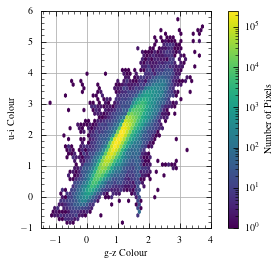

In [10]:
fig, ax = plt.subplots()
hb = ax.hexbin(
    gz_colour_vorbin.flatten(),
    ui_colour_vorbin.flatten(),
    gridsize=50,
    bins="log",
    mincnt=1,
    cmap="viridis",
    linewidths=0,
    # extent=[
    #     np.nanmin(gz_colour_vorbin),
    #     np.nanmax(gz_colour_vorbin),
    #     np.nanmin(ui_colour_vorbin),
    #     np.nanmax(ui_colour_vorbin),
    # ],
    zorder=2,
)
cbar = fig.colorbar(hb)
cbar.set_label("Number of Pixels")
ax.set_xlabel("g-z Colour")
ax.set_ylabel("u-i Colour")
ax.set_aspect("equal")
ax.set_xticks(np.arange(-1, 5).astype(int))
ax.set_ylim(-1, 6)
# ax.plot([-1, 4], [-1, 4], "k")  # y=x line
# fig.savefig(LOOKUP_PATH + "TOTAL_no4189_ui_vs_gz_extinctionCorr_hexbin_v2.pdf")
plt.show()

## 4.1 Make hexbin plots of each galaxy overlaid on the hexbin plot containing data from all galaxies

Optional, but useful for finding which galaxy corresponds to which areas of our
colour-colour space.

Note that all the hexbin plots have been extinction-corrected.


Load NGVS catalogue for extinction coefficients


In [ ]:
ngvs_catalogue = pd.read_csv("/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS_catalogue.txt", sep=" ", low_memory=False)
ngvs_catalogue

Following are the galaxies to overlay on the hexbin plot from above. These should be the
same galaxies as those used to generate the hexbin plot containing data from all galaxies.

The `INCLINATION` list is only to add an asterisk next to highly-inclined (i.e., $i \geq
80^\circ$) galaxy names. This is not required.

Using the VCC number of each galaxy, we find its extinction coefficients in each band.
Since NGC 4651 does not have a VCC number, we instead find the entry in the NGVS catalogue
that most closely matches the coordinates of NGC 4651.


In [4]:
GALAXIES = [
    "IC3392",
    # "NGC4189",  # ignored flag map, but bad results
    "NGC4192",
    "NGC4216",  # has unflagged foreground star
    "NGC4222",
    "NGC4254",
    "NGC4294",
    "NGC4298",
    "NGC4299",
    "NGC4302",
    "NGC4321",
    "NGC4330",
    "NGC4351",
    "NGC4380",
    "NGC4383",
    "NGC4388",
    "NGC4396",
    "NGC4402",
    "NGC4405",
    "NGC4419",
    "NGC4424",
    "NGC4450",
    "NGC4501",
    "NGC4522",
    "NGC4532",
    "NGC4535",
    "NGC4548",
    "NGC4567",
    "NGC4568",
    "NGC4569",
    "NGC4579",
    "NGC4580",
    # "NGC4606",  # flag map too intrusive
    "NGC4607",
    "NGC4651",
    "NGC4654",
    "NGC4689",
    "NGC4694",
]
VCC_GALAXIES = [
    1126,  # IC3392
    # 89,  # NGC4189, ignored flag map, but bad results
    92,  # NGC4192
    167,  # NGC4216, has unflagged foreground star
    187,  # NGC4222
    307,  # NGC4254
    465,  # NGC4294
    483,  # NGC4298
    491,  # NGC4299
    497,  # NGC4302
    596,  # NGC4321
    630,  # NGC4330
    692,  # NGC4351
    792,  # NGC4380
    801,  # NGC4383
    836,  # NGC4388
    865,  # NGC4396
    873,  # NGC4402
    874,  # NGC4405
    958,  # NGC4419
    979,  # NGC4424
    1110,  # NGC4450
    1401,  # NGC4501
    1516,  # NGC4522
    1554,  # NGC4532
    1555,  # NGC4535
    1615,  # NGC4548
    1673,  # NGC4567
    1676,  # NGC4568
    1690,  # NGC4569
    1727,  # NGC4579
    1730,  # NGC4580
    # 1859,  # NGC4606, flag map too intrusive
    1868,  # NGC4607
    -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
    1987,  # NGC4654
    2058,  # NGC4689
    2066,  # NGC4694
]
INCLINATIONS = [
    68,
    # 42,  # ignored flag map, but bad results
    83,
    90,  # has unflagged foreground star
    90,
    39,
    74,
    52,
    14,
    90,
    32,
    90,
    48,
    61,
    56,
    83,
    83,
    80,
    46,
    74,
    61,
    51,
    65,
    82,
    64,
    48,
    37,
    49,
    70,
    69,
    40,
    46,
    # 69,  # flag map too intrusive
    90,
    53,
    61,
    38,
    62,
]

ngvs_ra = ngvs_catalogue["NGVS_ra(deg)"]
ngvs_dec = ngvs_catalogue["NGVS_dec(deg)"]
vcc_name = ngvs_catalogue["VCC_name"]
extinctions = ngvs_catalogue["e(B-V)"]

# Entry that is closest to NGC4651 coordinates
NGC4651_row = vcc_name[
    (abs(ngvs_ra - 190.927625) < 0.1) & (abs(ngvs_dec - 16.39338889) < 0.1)
].index.values[0]

# E(B-V) to u, g, i, z extinction coefficients
# (from http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/query/catdoc.html#ebv)
EBV_u = 4.594
EBV_g = 3.560
EBV_i = 1.813
EBV_z = 1.221


Below, we are just repeating the steps we did to process the data used to generate the
hexbin plot from step 4 (not step 4.1).

We will generate 1 plot per galaxy showing its Voronoi bins in our colour-colour space
overlaid on the hexbin plot containing the Voronoi bins of all our galaxies.


In [5]:
import re
#
# Load data for 1 galaxy
# 
for galaxy, i, vcc_galaxy in zip(GALAXIES, INCLINATIONS, VCC_GALAXIES):
    galaxy_inputs_infile = LOOKUP_PATH + f"{galaxy}_lookupInputs.pkl"  # you may need to change this
    with open(galaxy_inputs_infile, "rb") as f:
        file = dill.load(f)
        gal_uband_signal = file["uband_signal"]
        gal_uband_noise = file["uband_noise"]
        gal_gband_signal = file["gband_signal"]
        gal_gband_noise = file["gband_noise"]
        gal_iband_signal = file["iband_signal"]
        gal_iband_noise = file["iband_noise"]
        gal_zband_signal = file["zband_signal"]
        gal_zband_noise = file["zband_noise"]
        gal_px_per_bin = file["px_per_bin"]
        file = None  # free memory
    if galaxy == "NGC4216":
        # Manually remove g-z colours <= 0 for NGC 4216
        # (i.e., colours corresponding to area around foreground star)
        is_good = fu.calc_colour(gal_gband_signal, gal_zband_signal) > 0
        gal_uband_signal = gal_uband_signal[is_good]
        gal_uband_noise = gal_uband_noise[is_good]
        gal_gband_signal = gal_gband_signal[is_good]
        gal_gband_noise = gal_gband_noise[is_good]
        gal_iband_signal = gal_iband_signal[is_good]
        gal_iband_noise = gal_iband_noise[is_good]
        gal_zband_signal = gal_zband_signal[is_good]
        gal_zband_noise = gal_zband_noise[is_good]
        gal_px_per_bin = gal_px_per_bin[is_good]
    # 
    # Normalize fluxes by number of pixels
    # 
    gal_uband_signal = gal_uband_signal / gal_px_per_bin
    gal_uband_noise = gal_uband_noise / gal_px_per_bin
    gal_gband_signal = gal_gband_signal / gal_px_per_bin
    gal_gband_noise = gal_gband_noise / gal_px_per_bin
    gal_iband_signal = gal_iband_signal / gal_px_per_bin
    gal_iband_noise = gal_iband_noise / gal_px_per_bin
    gal_zband_signal = gal_zband_signal / gal_px_per_bin
    gal_zband_noise = gal_zband_noise / gal_px_per_bin
    # 
    # Calculate relative AB magnitudes
    # 
    gal_uband_relmag, gal_uband_mag_err = fu.calc_mag(gal_uband_signal, gal_uband_noise, calc_abs=False)
    gal_gband_relmag, gal_gband_mag_err = fu.calc_mag(gal_gband_signal, gal_gband_noise, calc_abs=False)
    gal_iband_relmag, gal_iband_mag_err = fu.calc_mag(gal_iband_signal, gal_iband_noise, calc_abs=False)
    gal_zband_relmag, gal_zband_mag_err = fu.calc_mag(gal_zband_signal, gal_zband_noise, calc_abs=False)
    # 
    # Correct for extinction
    # 
    if galaxy != "NGC4651":
        ebv_coeff = extinctions[vcc_name == vcc_galaxy].values
        if ebv_coeff.size != 1:
            raise ValueError(f"More than one E(B-V) coefficient found for {gal}")
        ebv_coeff = ebv_coeff[0]
    else:
        ebv_coeff = extinctions.iloc[NGC4651_row]
    gal_uband_relmag = gal_uband_relmag - ebv_coeff * EBV_u
    gal_gband_relmag = gal_gband_relmag - ebv_coeff * EBV_g
    gal_iband_relmag = gal_iband_relmag - ebv_coeff * EBV_i
    gal_zband_relmag = gal_zband_relmag - ebv_coeff * EBV_z
    # 
    # Calculate colours
    # 
    gal_gz_colour_vorbin = gal_gband_relmag - gal_zband_relmag
    gal_ui_colour_vorbin = gal_uband_relmag - gal_iband_relmag
    # 
    # Plot
    # 
    fig, ax = plt.subplots()
    hb = ax.hexbin(
        gz_colour_vorbin.flatten(),
        ui_colour_vorbin.flatten(),
        gridsize=50,
        bins="log",  # will change the get_array() values
        mincnt=1,
        cmap="Blues",
        linewidths=0,
        alpha=0.5,
        # extent=[
        #     np.nanmin(gz_colour_vorbin),
        #     np.nanmax(gz_colour_vorbin),
        #     np.nanmin(ui_colour_vorbin),
        #     np.nanmax(ui_colour_vorbin),
        # ],
        zorder=2,
    )
    hb2 = ax.hexbin(
        gal_gz_colour_vorbin.flatten(),
        gal_ui_colour_vorbin.flatten(),
        gridsize=50,
        bins="log",  # will change the get_array() values
        mincnt=1,
        cmap="viridis",
        linewidths=0,
        # extent=[
        #     np.nanmin(gz_colour_vorbin),
        #     np.nanmax(gz_colour_vorbin),
        #     np.nanmin(ui_colour_vorbin),
        #     np.nanmax(ui_colour_vorbin),
        # ],
        alpha=0.5,
        zorder=4,
    )
    cbar2 = fig.colorbar(hb2)
    cbar2.solids.set(alpha=1)  # opaque colour bar
    cbar2.set_label("Number of Pixels")
    ax.set_xlabel("g-z Colour")
    ax.set_ylabel("u-i Colour")
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(-1, 5).astype(int))
    ax.set_ylim(-1, 6)
    #
    # Add name of galaxy
    #
    high_i_str = "*" if i >= 80 else ""
    ax.text(
        0.9,
        0.9,
        re.sub(r"(\d+)", " \\1", galaxy) + high_i_str,
        c="k",
        ha="right",
        transform=ax.transAxes,
    )
    fig.savefig(LOOKUP_PATH + f"{galaxy}_ui_vs_gz_overlay.pdf")
    plt.close()
print("Done!")

Done!


# 5. Make lookup table values and determine lookup cell of each pixel

Make lookup table spanning a g-z range of $[-1.0, 3.8]$ and u-i range of $[-0.8, 5.5]$
with bin sizes of 0.1 and 0.1 along each axis, respectively (these values chosen based on
hexbin plot). Additionally, we assign points beyond these colour limits to their closest
bin.


In [3]:
# Set the following 4 parameters
GZ_STEP = 0.1
UI_STEP = 0.1
gz_vals = np.arange(-1.0, 3.8 + GZ_STEP, GZ_STEP)  # the range of g-z
ui_vals = np.arange(-0.8, 5.5 + UI_STEP, UI_STEP)  # the range of u-i
# 
LOOKUP_GZ_LEN = gz_vals.size
LOOKUP_UI_LEN = ui_vals.size
print(gz_vals.min(), gz_vals.max(), LOOKUP_GZ_LEN)
print(ui_vals.min(), ui_vals.max(), LOOKUP_UI_LEN)
gz_spacing = np.diff(gz_vals)[0]
ui_spacing = np.diff(ui_vals)[0]
print("gz_spacing:", gz_spacing)
print("ui_spacing:", ui_spacing)
print()
#
# Assign each pixel to its bin. If values beyond the edges of the lookup table, assign to
# closest bin
#
# Since the *_vals arrays are increasing & right=False, the returned index satisfies:
# bins[i] <= x < bins[i+1] (since I subtracted 1 from the bin number)
gz_idx = np.digitize(gz_colour_vorbin, gz_vals, right=False) - 1
ui_idx = np.digitize(ui_colour_vorbin, ui_vals, right=False) - 1
# #
# # Assign points beyond g-z and u-i ranges to closest bin (method 1)
# #
# gz_idx[gz_idx == LOOKUP_GZ_LEN] = LOOKUP_GZ_LEN - 1
# ui_idx[ui_idx == LOOKUP_UI_LEN] = LOOKUP_UI_LEN - 1
# gz_idx[gz_idx < 0] = 0
# ui_idx[ui_idx < 0] = 0
#
# Assign bad values to negative indices
#
gz_idx_mask = np.isnan(gz_colour_vorbin)
ui_idx_mask = np.isnan(ui_colour_vorbin)
gz_idx[gz_idx_mask] = -1
ui_idx[ui_idx_mask] = -1
#
# Assign points beyond g-z and u-i ranges to closest bin (method 2)
#
gz_idx[gz_colour_vorbin <= gz_vals.min()] = 0
ui_idx[ui_colour_vorbin <= ui_vals.min()] = 0
gz_idx[gz_colour_vorbin >= gz_vals.max()] = LOOKUP_GZ_LEN - 1
ui_idx[ui_colour_vorbin >= ui_vals.max()] = LOOKUP_UI_LEN - 1

-1.0 3.799999999999999 49
-0.8 5.499999999999999 64
gz_spacing: 0.09999999999999998
ui_spacing: 0.09999999999999998



In [4]:
#
# Make pandas dataframe containing the bins in the rows and band fluxes in the columns.
# The row headers will have a format <g-z bin>_<u-i bin>
#
rows = []
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        rows.append(f"{gz_bin}_{ui_bin}")
lookup_df = pd.DataFrame(
    columns=["u", "u_err", "g", "g_err", "i", "i_err", "z", "z_err"], index=rows
).astype("object")
print(lookup_df)
# print(lookup_df.dtypes)


         u u_err    g g_err    i i_err    z z_err
0_0    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_1    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_2    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_3    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
0_4    NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
...    ...   ...  ...   ...  ...   ...  ...   ...
48_59  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_60  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_61  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_62  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN
48_63  NaN   NaN  NaN   NaN  NaN   NaN  NaN   NaN

[3136 rows x 8 columns]


In [5]:
#
# Populate pandas dataframe. Depending on size of lookup table, may take over a minute.
# Can speed up for loop with numba (since all arrays should be 1D anyway)
#
nan_arr = np.array([np.nan])  # for assigning to empty colour-colour cells


def _assign_to_df(_band, _mask):
    _tmp_arr = _band[_mask]
    if _tmp_arr.size == 0:
        _tmp_arr = nan_arr
    return _tmp_arr

for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_mask = (gz_idx == gz_bin) & (ui_idx == ui_bin)
        lookup_df.at[tmp_row, "u"] = _assign_to_df(uband_mag, tmp_mask)
        lookup_df.at[tmp_row, "u_err"] = _assign_to_df(uband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "g"] = _assign_to_df(gband_mag, tmp_mask)
        lookup_df.at[tmp_row, "g_err"] = _assign_to_df(gband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "i"] = _assign_to_df(iband_mag, tmp_mask)
        lookup_df.at[tmp_row, "i_err"] = _assign_to_df(iband_mag_err, tmp_mask)
        lookup_df.at[tmp_row, "z"] = _assign_to_df(zband_mag, tmp_mask)
        lookup_df.at[tmp_row, "z_err"] = _assign_to_df(zband_mag_err, tmp_mask)


In [6]:
# View lookup table
lookup_df

,u,u_err,g,g_err,i,i_err,z,z_err
0_0,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
0_1,[-8.572376354686202],[0.00413336223345164],[-8.986999362763129],[0.0024139724699263065],[-7.97223071519997],[0.006864405962277088],[-8.071373567425603],[0.008511120773036543]
0_2,"[-9.126110834410813, -8.859393784258025, -9.08...","[0.0031781945827393057, 0.003605315780787221, ...","[-9.601332732821163, -9.34683574454391, -9.547...","[0.0018013226171760394, 0.0020322833064388294,...","[-8.584671110697794, -8.305164598718449, -8.51...","[0.004837243763103177, 0.005654780479413437, 0...","[-8.640155347030124, -8.329416611829586, -8.48...","[0.00593721742459055, 0.007199478747176044, 0...."
0_3,"[-9.290212490091385, -8.967736910413912, -8.86...","[0.0029419924316119654, 0.0034249711697008594,...","[-9.723440184706508, -9.479229915874377, -9.46...","[0.001700457332294737, 0.0019084741066294415, ...","[-8.87583891123024, -8.560515113855935, -8.437...","[0.004133538257176972, 0.004901914935850859, 0...","[-8.766450774461951, -8.547693713253256, -8.37...","[0.005503959872058062, 0.006281672840989552, 0..."
0_4,"[-9.220575614786775, -8.892118366288358]","[0.00303991151005632, 0.0035498130459413447]","[-9.748168770346961, -9.458809381132387]","[0.001680759375025313, 0.0019270389748884263]","[-8.858129445073018, -8.547950465033384]","[0.004172656978722331, 0.004935970745915109]","[-8.703048388094224, -8.426538654041256]","[0.005716338332448339, 0.0067717325450275]"
...,...,...,...,...,...,...,...,...
48_59,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_60,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_61,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]
48_62,[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan]


In [7]:
# 
# The longest row in each band should be the same length. Use this as quick check
# 
def get_longest_row(df, col):
    return max(df[col], key=len)

print(len(get_longest_row(lookup_df, "u")))
print(len(get_longest_row(lookup_df, "u_err")))
print(len(get_longest_row(lookup_df, "g")))
print(len(get_longest_row(lookup_df, "g_err")))
print(len(get_longest_row(lookup_df, "i")))
print(len(get_longest_row(lookup_df, "i_err")))
print(len(get_longest_row(lookup_df, "z")))
print(len(get_longest_row(lookup_df, "z_err")))
print(get_longest_row(lookup_df, "u"))
print(get_longest_row(lookup_df, "u_err"))
print(get_longest_row(lookup_df, "g"))
print(get_longest_row(lookup_df, "g_err"))
print(get_longest_row(lookup_df, "i"))
print(get_longest_row(lookup_df, "i_err"))
print(get_longest_row(lookup_df, "z"))
print(get_longest_row(lookup_df, "z_err"))


245129
245129
245129
245129
245129
245129
245129
245129
[-6.18700893 -6.11863132 -6.16454055 ... -4.4757923  -3.95497646
 -3.67825754]
[0.01268942 0.01320601 0.01285635 ... 0.02134565 0.02257297 0.01917372]
[-7.25886317 -7.22365776 -7.25608974 ... -5.64541592 -5.17203933
 -4.66114899]
[0.00503421 0.00513009 0.00504169 ... 0.00818799 0.00808534 0.00808093]
[-8.22643035 -8.19238002 -8.22902852 ... -6.5465479  -6.02345649
 -5.75764003]
[0.00555345 0.00566302 0.0055452  ... 0.01062661 0.01128763 0.00951405]
[-8.42010353 -8.38157804 -8.43373626 ... -6.7478561  -6.27384163
 -5.84913458]
[0.00643539 0.00659636 0.0063796  ... 0.01303503 0.01357324 0.01320876]


# 6. Export results for SED fitting

Randomly sample at most 10 points per lookup table cell and export all the data in 1 text
file for Dr. Roediger. These will be the data for SED fitting.


In [8]:
# 
# Set the following 2 parameters
# 
MAX_PX_PER_BIN = 10  # max number of pixels to sample per lookup table cell
RNG_SEED = 761  # random number generator seed
# 
selected_pixels = []  # list to store all selected pixels (will be converted to ASCII file for Dr. Roediger)
selected_pixels.append(
    ["id", "z", "u_mag", "u_mag_err", "g_mag", "g_mag_err", "i_mag", "i_mag_err", "z_mag", "z_mag_err"]
)  # add headers as first row of the text file
rng = np.random.default_rng(RNG_SEED)
len_digits = max([len(str(LOOKUP_GZ_LEN)), len(str(LOOKUP_UI_LEN))])  # for formatting ID column
# 
# Sample at most MAX_PX_PER_BIN pixels per lookup table cell
# 
num_nans = 0
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        tmp_row = f"{gz_bin}_{ui_bin}"
        tmp_series = lookup_df.loc[tmp_row]
        tmp_num_px = tmp_series.values[0].size  # number of pixels in the bin
        if tmp_num_px > MAX_PX_PER_BIN:
            tmp_row_idx = rng.choice(tmp_num_px, size=MAX_PX_PER_BIN, replace=False).astype(int)
            tmp_row_idx = np.sort(tmp_row_idx)
        else:
            tmp_row_idx = range(tmp_num_px)
        # ID of data point in the format <gz bin><ui bin><pixel index>
        # (e.g., "013142" for gz bin 1, ui bin 31, pixel index 2)
        # Pixel index runs from [0, MAX_PX_PER_BIN-1] (e.g., 0 to 9)
        tmp_id = str(gz_bin).zfill(len_digits) + str(ui_bin).zfill(len_digits)
        if tmp_num_px == 1:
            if np.isnan(float(tmp_series["u"])):  # don't bother adding NaNs
                num_nans += 1
                continue
            selected_pixels.append(
                [
                    tmp_id + "0",
                    0.0,
                    float(tmp_series["u"]),
                    float(tmp_series["u_err"]),
                    float(tmp_series["g"]),
                    float(tmp_series["g_err"]),
                    float(tmp_series["i"]),
                    float(tmp_series["i_err"]),
                    float(tmp_series["z"]),
                    float(tmp_series["z_err"]),
                ]
            )
        else:
            for i, element in enumerate(tmp_row_idx):
                selected_pixels.append(
                    [
                        tmp_id + str(i),
                        0.0,
                        float(tmp_series["u"][element]),
                        float(tmp_series["u_err"][element]),
                        float(tmp_series["g"][element]),
                        float(tmp_series["g_err"][element]),
                        float(tmp_series["i"][element]),
                        float(tmp_series["i_err"][element]),
                        float(tmp_series["z"][element]),
                        float(tmp_series["z_err"][element]),
                    ]
                )
print("Number of empty bins in lookup table:", num_nans)

Number of empty bins in lookup table: 1922


In [9]:
# 
# Save the selected pixels to text file for SED fitting
# 
import csv

selected_pixels_filename = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupMagnitudes.txt"  # change this to your desired filename
with open(selected_pixels_filename, "w") as f:
    wr = csv.writer(f, delimiter=" ")
    wr.writerows(selected_pixels)
print("Saved", selected_pixels_filename)

Saved /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupMagnitudes.txt


# 7. Read SED fitting results and compile into 1 array

(Do this once SED fitting is complete)

The SED results should be text files each containing 1 row of ASCII-formatted data. 1 text
file per data point that was SED fitted.

The SED result filenames are assumed to be in the format
`prospectorFit_emcee_<NUMS>_results.txt` where `<NUMS>` is some integer. This assumption
can be changed in `load_sed_results()`. See the docstring (in `fits_utils.py`) for more
information.


In [2]:
# Below are files to skip because SED did not converge or because of file transfer problem
sed_skip = [
    287,
    4325,  # empty file
]
print("Number of skipped SED files:", len(sed_skip))
#
# Load all SED results into 1 array (I/O is slow, especially the first time!)
# 
sed_results = fu.load_sed_results(
    "/arc/home/IsaacCheng/coop_f2021/sed_fits/lookup_table/",  # the directory containing all SED results
    nmax=7888,  # the max number in filename for SED results (inclusive)
    skip=sed_skip,  # list of SED files to skip
    print_every=1000,  # optional. Print a message every this number of SED files
)
print("Done reading SED results")

Number of skipped SED files: 2
On file: 0
On file: 1000
On file: 2000
On file: 3000
On file: 4000
On file: 5000
On file: 6000
On file: 7000
Done reading SED results


In [3]:
# Put SED results into pandas DataFrame (I don't think I ever used this DataFrame)
sed_results_df = pd.DataFrame(sed_results)

In [4]:
#
# Save results (so we don't have to suffer through slow IO every time)
#
sed_results_outfile = LOOKUP_PATH + "sed_results_no4189.pkl"  # change this to your desired filename
with open(sed_results_outfile, "wb") as f:
    dill.dump(
        {
            "sed_results_arr": sed_results,
            "sed_results_df": sed_results_df,
        },
        f
    )
print("Pickled", sed_results_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/sed_results_no4189.pkl


# 8. Make lookup table

For each cell in our lookup table, we calculate the median mass-to-light ratio (MLi) as
the representative MLi value for any pixel that may fall into that cell in our
colour-colour space.

For our uncertainties, we just use the median mass-to-light ratio errors. I didn't use the
standard deviation of our data in each cell as the uncertainty because cells with just 1
data point will have a standard deviation of zero.


In [2]:
# 
# Load SED data from pickle file
#
P50_MASS_COL = 4  # the column number (from 0) of the 50th percentile mass in the SED data
P16_MASS_COL = 5  # the column number (from 0) of the 16th percentile mass in the SED data
P84_MASS_COL = 6  # the column number (from 0) of the 84th percentile mass in the SED data
# 
sed_results_infile = LOOKUP_PATH + "sed_results_no4189.pkl"  # change this to match filename above
with open(sed_results_infile, "rb") as f:
    file = dill.load(f)
    sed_results = file["sed_results_arr"]
    sed_results_df = file["sed_results_df"]
    file = None  # free memory
p50_masses = sed_results[:, P50_MASS_COL].astype(float)
p16_masses = sed_results[:, P16_MASS_COL].astype(float)
p84_masses = sed_results[:, P84_MASS_COL].astype(float)
p50_masses_err = 0.5 * (p84_masses - p16_masses)
print(np.sum(~np.isfinite(p50_masses)))
print(np.sum(~np.isfinite(p16_masses)))
print(np.sum(~np.isfinite(p84_masses)))

2
2
2


In [3]:
#
# Split ID back into bins
# Recall:
#     ID of data point in the format <gz bin><ui bin><pixel index>
#     (e.g., "013142" for gz bin 1, ui bin 31, pixel index 2)
#     Pixel index runs from [0, MAX_PX_PER_BIN-1] (e.g., 0 to 9)
#
sed_gz_bins = []
sed_ui_bins = []
for px in range(sed_results.shape[0]):
    tmp_id = sed_results[px][0]  # first (0th) column is ID
    if type(tmp_id) != str:
        sed_gz_bins.append(np.nan)
        sed_ui_bins.append(np.nan)
    else:
        sed_gz_bins.append(tmp_id[:2])  # assume gz bin is 2 digits
        sed_ui_bins.append(tmp_id[2:4])  # assume ui bin is 2 digits
# Convert to numpy arrays
sed_gz_bins = np.asarray(sed_gz_bins).astype(float)
sed_ui_bins = np.asarray(sed_ui_bins).astype(float)
# 
print(sed_gz_bins.shape)
print(sed_ui_bins.shape)
print(sed_gz_bins)
print(sed_ui_bins)
print(np.sum(~np.isfinite(sed_gz_bins)))
print(np.sum(~np.isfinite(sed_ui_bins)))

(7889,)
(7889,)
[ 0.  0.  0. ... 46. 47. 47.]
[ 1.  2.  2. ... 60. 61. 62.]
2
2


In [4]:
# 
# Load SED inputs (i.e., the extinction-corrected absolute AB magnitude data)
# 
selected_pixels_infile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupMagnitudes.txt"
sed_inputs = pd.read_csv(selected_pixels_infile, sep=" ", dtype=str)
# Convert all columns except for id column to floats
for col in range(1, sed_inputs.shape[1]):
    sed_inputs.iloc[:, col] = sed_inputs.iloc[:, col].astype(float)
abs_i_mag = sed_inputs["i_mag"].values
abs_i_mag_err = sed_inputs["i_mag_err"].values
sed_inputs

,id,z,u_mag,u_mag_err,g_mag,g_mag_err,i_mag,i_mag_err,z_mag,z_mag_err
0,00010,0.0,-8.572376,0.004133,-8.986999,0.002414,-7.972231,0.006864,-8.071374,0.008511
1,00020,0.0,-9.126111,0.003178,-9.601333,0.001801,-8.584671,0.004837,-8.640155,0.005937
2,00021,0.0,-8.859394,0.003605,-9.346836,0.002032,-8.305165,0.005655,-8.329417,0.007199
3,00022,0.0,-9.082988,0.003243,-9.547684,0.001848,-8.519234,0.005015,-8.485181,0.006529
4,00023,0.0,-8.984504,0.003398,-9.541081,0.001853,-8.398959,0.005363,-8.427556,0.006767
...,...,...,...,...,...,...,...,...,...,...
7884,45610,0.0,-5.060588,0.020313,-7.176660,0.003993,-10.416765,0.001320,-10.760345,0.001340
7885,46530,0.0,-4.954059,0.021902,-6.705816,0.005194,-9.511230,0.002064,-10.312238,0.001679
7886,46600,0.0,-5.421332,0.022460,-7.471785,0.004825,-10.718313,0.001615,-11.120076,0.001588
7887,47610,0.0,-5.376669,0.023137,-7.466313,0.004838,-10.752176,0.001589,-11.178012,0.001543


In [5]:
#
# Make lookup table (2D array of mass-to-light ratios)
#
#
# 1. Set parameters
# (The first 4 must be the same as those used to generate the lookup table)
#
GZ_STEP = 0.1  # must be the same as the one used to generate the lookup table
UI_STEP = 0.1  # must be the same as the one used to generate the lookup table
gz_vals = np.arange(-1.0, 3.8 + GZ_STEP, GZ_STEP)  # must be the same as the one used to generate the lookup table
ui_vals = np.arange(-0.8, 5.5 + UI_STEP, UI_STEP)  # must be the same as the one used to generate the lookup table
SUN_ABS_I_MAG = 4.53  # absolute AB magnitude of Sun in i-band (FSPS)
AVG_FUNCTION = np.nanmedian  # np.nanmedian or np.nanmean. How we determine the "representative" MLi value per cell
#
LOOKUP_GZ_LEN = gz_vals.size
LOOKUP_UI_LEN = ui_vals.size
print(gz_vals.min(), gz_vals.max(), LOOKUP_GZ_LEN)
print(ui_vals.min(), ui_vals.max(), LOOKUP_UI_LEN)
gz_spacing = np.diff(gz_vals)[0]
ui_spacing = np.diff(ui_vals)[0]
print("gz_spacing:", gz_spacing)
print("ui_spacing:", ui_spacing)
print()
if AVG_FUNCTION == np.nanmedian:
    AVG_FUNCTION_STR = "median"
elif AVG_FUNCTION == np.nanmean:
    AVG_FUNCTION_STR = "mean"
else:
    raise ValueError("AVG_FUNCTION must be np.nanmedian or np.nanmean")
# 2. Create arrays to store final results
lookup_px_in_bin = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), 0, dtype=int)
lookup_MLi = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)
lookup_MLi_std = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)  # standard deviation of the N pixels in each bin
lookup_MLi_unc = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)  # uncertainty from SED fitting
lookup_MLi_unc_std = np.full((LOOKUP_GZ_LEN, LOOKUP_UI_LEN), np.nan)
# 3. Populate lookup table arrays
for gz_bin in range(LOOKUP_GZ_LEN):
    for ui_bin in range(LOOKUP_UI_LEN):
        #
        # Find proper cell in lookup table
        #
        # Since sed_gz_bins and sed_ui_bins are floats (may have NaNs), we use floating
        # point comparison below
        isgood_sed = (abs(sed_gz_bins - gz_bin) < 1e-12) & (
            abs(sed_ui_bins - ui_bin) < 1e-12
        )
        #
        # Store number of points in this cell
        #
        lookup_px_in_bin[gz_bin][ui_bin] = int(np.sum(isgood_sed))
        if isgood_sed.sum() == 0:
            continue  # all NaNs. Don't actually need this but prevents RuntimeWarning
        #
        # Calculate mass-to-light ratio and uncertainty. All in i-band
        #
        Li = 10 ** (-0.4 * (abs_i_mag[isgood_sed] - SUN_ABS_I_MAG))
        Li_err = Li * np.log(10) * 0.4 * abs_i_mag_err[isgood_sed]
        MLi = p50_masses[isgood_sed] / Li
        MLi_err = (
            np.sqrt(
                (p50_masses_err[isgood_sed] / p50_masses[isgood_sed]) ** 2
                + (Li_err / Li) ** 2
            )
            * MLi
        )
        #
        # Store quantities
        #
        lookup_MLi[gz_bin][ui_bin] = np.nanmedian(MLi)
        lookup_MLi_unc[gz_bin][ui_bin] = np.nanmedian(MLi_err)
        lookup_MLi_std[gz_bin][ui_bin] = np.nanstd(MLi)
        lookup_MLi_unc_std[gz_bin][ui_bin] = np.nanstd(MLi_err)

-1.0 3.799999999999999 49
-0.8 5.499999999999999 64
gz_spacing: 0.09999999999999998
ui_spacing: 0.09999999999999998



# 9. Save lookup table data


In [7]:
lookup_table_outfile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable.pkl"  # change this
with open(lookup_table_outfile, "wb") as f:
    dill.dump(
        {
            "README": "This file contains the mass-to-light ratio (MLi) lookup table where mass is from SED fitting and luminosity is from i-band extinction-corrected fluxes "
            + f"(assuming the Sun has an absolute i-band AB magnitude of {SUN_ABS_I_MAG} from FSPS). Note that the absolute i-band AB magnitude of the Sun has not been corrected for extinction (doesn't make sense to).\n"
            + "1. `average_function` specifies if representative MLi is from mean or median.\n"
            + "2. & 3. `gz_vals` and `ui_vals` are the g-z and u-i colours used in the lookup table, respectively.\n"
            + "N.B. for #4-8: The first index of `px_in_bin`, `MLi`, `MLi_std`, `MLi_unc`, and `MLi_unc_std` correspond to gz_vals; their 2nd index corresponds to ui_vals (check their shapes if you're confused). "
            + "For example, MLi[0] selects all the colour-colour bins corresponding to gz_vals[0]. Similarly, MLi[:, 0] selects all the colour-colour bins corresponding to ui_vals[0].\n"
            + "4. `px_in_bin` gives the number of Voronoi bins used to calculate the representative MLi and associated values. We decided to sample a maximum of 10 unique Voronoi bins per colour-colour bin to SED fit (hence why the max `px_in_bin` is 10).\n"
            + "5. `MLi` contains the representative mass-to-light ratio per colour-colour bin. Again, the luminosity is from i-band extinction-corrected fluxes. Also see `average_function` for description of how we determine the 'representative' value (i.e., mean or median).\n"
            + "6. MLi_std of each colour-colour bin is the standard deviation of the N (0 <= N <= 10) MLi values in that colour-colour bin used to calculate the representative MLi. This may not be that useful.\n"
            + "7. MLi_unc is the representative mass-to-light ratio uncertainty (again, see `average_function`). The error in the SED fitted masses is half of the difference between the 84th and 16th stellar mass percentiles. N.B. we assume the errors in the SED fitted masses and their i-band luminosities are independent of each other.\n"
            + "8. MLi_unc_std of each colour-colour bin is the standard deviation of the N (0 <= N <= 10) MLi_unc values in that colour-colour bin used to calculate the representative MLi_unc.",
            "average_function": AVG_FUNCTION_STR,  # "mean" or "median"
            "gz_vals": gz_vals,
            "ui_vals": ui_vals,
            "px_in_bin": lookup_px_in_bin,
            "MLi": lookup_MLi,
            "MLi_std": lookup_MLi_std,
            "MLi_unc": lookup_MLi_unc,
            "MLi_unc_std": lookup_MLi_unc_std,
        },
        f
    )
print("Pickled", lookup_table_outfile)

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/lookup_table/TOTAL_no4189_extinctionCorr_lookupTable.pkl


# 10. Make plot showing lookup table results


In [2]:
# 
# Load lookup table data
# 
lookup_table_infile = LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable.pkl"
with open(lookup_table_infile, "rb") as f:
    file = dill.load(f)
    print(file["README"])
    avg_func = file["average_function"]
    gz_vals = file["gz_vals"]
    ui_vals = file["ui_vals"]
    px_in_bin = file["px_in_bin"]
    MLi = file["MLi"]
    MLi_unc = file["MLi_unc"]
    MLi_std = file["MLi_std"]
    file = None  # free memory


This file contains the mass-to-light ratio (MLi) lookup table where mass is from SED fitting and luminosity is from i-band extinction-corrected fluxes (assuming the Sun has an absolute i-band AB magnitude of 4.53 from Taylor+2011). Note that the absolute i-band AB magnitude of the Sun has not been corrected for extinction (doesn't make sense to).
1. `average_function` specifies if representative MLi is from mean or median.
2. & 3. `gz_vals` and `ui_vals` are the g-z and u-i colours used in the lookup table, respectively.
N.B. for #4-8: The first index of `px_in_bin`, `MLi`, `MLi_std`, `MLi_unc`, and `MLi_unc_std` correspond to gz_vals; their 2nd index corresponds to ui_vals (check their shapes if you're confused). For example, MLi[0] selects all the colour-colour bins corresponding to gz_vals[0]. Similarly, MLi[:, 0] selects all the colour-colour bins corresponding to ui_vals[0].
4. `px_in_bin` gives the number of Voronoi bins used to calculate the representative MLi and associated val

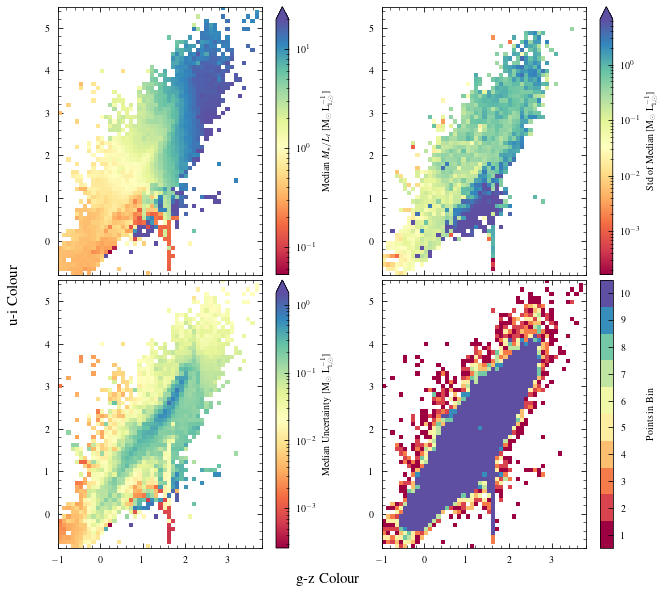

In [3]:
#
# 4-panel plot of MLi, MLi_unc, MLi_std, & points per lookup cell
#
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=2*mpl.figure.figaspect(0.95), sharex=True
)
ax1, ax3, ax2, ax4 = axs.flatten()  # top left, bottom left, top right, bottom right
ax_extent = [gz_vals[0], gz_vals[-1], ui_vals[0], ui_vals[-1]]
cbar_fraction = 0.048
# MLi
img1 = ax1.imshow(
    MLi.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=20),
    zorder=2,
    interpolation="none",
)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=cbar_fraction, extend="max")
cbar1.set_label(f"{avg_func.capitalize()} " + r"$M_\star / L_i$ [$\rm M_\odot\; L_{i, \odot}^{-1}$]")
# ax1.set_ylabel("u-i Colour")
ax1.set_aspect("equal")
ax1.grid(False)
# MLi uncertainty
img2 = ax2.imshow(
    MLi_unc.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=1.5),
    zorder=2,
    interpolation="none",
)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=cbar_fraction, extend="max")
cbar2.set_label(f"{avg_func.capitalize()} Uncertainty " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]")
# ax2.set_xlabel("g-z Colour")
# ax2.set_ylabel("u-i Colour")
ax2.set_xticks(gz_vals[::10])
ax2.set_aspect("equal")
ax2.grid(False)
# Std of MLi
img3 = ax3.imshow(
    MLi_std.T,
    extent=ax_extent,
    origin="lower",
    cmap="Spectral",
    norm=mpl.colors.LogNorm(vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95)),
    zorder=2,
    interpolation="none",
    # vmax=np.percentile(MLi_std[np.isfinite(MLi_std)], 95),
)
cbar3 = fig.colorbar(img3, ax=ax3, fraction=cbar_fraction, extend="max")
cbar3.set_label(f"Std of {avg_func.capitalize()} " + r"[$\rm M_\odot\; L_{i, \odot}^{-1}$]")
ax3.tick_params(labelbottom=False)
# ax3.set_ylabel("u-i Colour")
ax3.set_aspect("equal")
ax3.grid(False)
# Data points per colour-colour bin
px_in_bin_masked = np.ma.masked_where(px_in_bin == 0, px_in_bin)
px_in_bin_cmap = mpl.cm.get_cmap("Spectral", 10)
img4 = ax4.imshow(
    px_in_bin_masked.T,
    extent=ax_extent,
    origin="lower",
    cmap=px_in_bin_cmap,
    zorder=2,
    interpolation="none",
    # # To align major ticks in centre of discrete colour bar sections
    vmin=0.5,
    vmax=10.5,
)
cbar4 = fig.colorbar(img4, ax=ax4, fraction=cbar_fraction)
cbar4.set_label(r"Points in Bin", labelpad=15)
cbar4.set_ticks(np.arange(1, 11).astype(int))
cbar4.minorticks_off()
# ax4.set_xlabel("g-z Colour")
ax4.set_xticks(gz_vals[::10])
ax4.set_aspect("equal")
ax4.grid(False)
fig.text(0.53, 0.0, "g-z Colour", ha="center", fontsize=15, color="k")
fig.text(
    0.0,
    0.5,
    "u-i Colour",
    va="center",
    rotation="vertical",
    fontsize=15,
    color="k",
)
plt.subplots_adjust(left=0.001, right=1.0, bottom=0.06, top=1.0, wspace=0.15, hspace=0.02)
# fig.savefig(LOOKUP_PATH + "TOTAL_no4189_extinctionCorr_lookupTable_unc+std+points.pdf")
plt.show()